![HanksTeam](https://baseballhall.org/sites/default/files/styles/header_image_1800_w/public/Aaron%20Hank%20312.68_Grp_NBL.jpg?itok=ekmrvcZs "Hank Aaron poses with fellow Hall of Famer Eddie Mathews (center), and Braves first baseman Joe Adcock, while playing for the Milwaukee Braves. (National Baseball Hall of Fame)")

### Build a better Pipeline

In [1]:
cd ..

/Users/johnphillips/Desktop/DSI/BaseBall


In [2]:
%matplotlib inline

In [3]:
%run __init__.py

In [4]:
# Start with reading the data sets from the pickles
teams = pd.read_pickle('data/teams.p')
teams_num = pd.read_pickle('data/teams_num.p')
new_reduced = pd.read_pickle('data/new_reduced.p')

### Separate X and y 

In [5]:
# Had to also drop Wins, Losses, and WinP since those are direct indicators.
# And they are not part of a players individual stats.
X = teams_num.drop(['WSWin', 'LgWin', 'W', 'L', 'WinP'], axis=1) 

# Make a y2 based upon Winning Leage Series, for possible second model.
y = teams_num['WSWin']
y2 = teams_num['LgWin'] 

In [6]:
# Train-test split our data...

# Standard split:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.33)

# Second split based upon LgWin target:
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, random_state = 42, test_size=0.33)

In [7]:
# Don't forget scaled data:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### GridSearch CV & Pipelines

In [8]:
# Basics to start...
knc_params = {
    'n_neighbors': range(3,13,1)
}
knc_gs = GridSearchCV(KNeighborsClassifier(), param_grid= knc_params, cv=5)

In [9]:
knc_gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
cv_results = pd.DataFrame(knc_gs.cv_results_)
cv_results.sort_values('mean_test_score', ascending=False).head(4)

/Users/johnphillips/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/johnphillips/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/johnphillips/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/johnp

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
5,0.002006,0.027958,0.955240,0.955766,8,{u'n_neighbors': 8},1,0.952756,0.957181,0.957895,...,0.952632,0.956550,0.955145,0.956579,0.957784,0.955263,0.000264,0.000743,0.002303,0.001401
6,0.001939,0.028022,0.955240,0.956556,9,{u'n_neighbors': 9},1,0.955381,0.957181,0.955263,...,0.952632,0.956550,0.955145,0.958553,0.957784,0.956579,0.000083,0.000548,0.001631,0.001506
7,0.001920,0.028447,0.955240,0.955898,10,{u'n_neighbors': 10},1,0.952756,0.957181,0.957895,...,0.952632,0.955892,0.955145,0.956579,0.957784,0.955263,0.000053,0.000518,0.002303,0.000923
8,0.001928,0.028893,0.954713,0.956556,11,{u'n_neighbors': 11},4,0.952756,0.956522,0.957895,...,0.950000,0.957209,0.955145,0.958553,0.957784,0.955921,0.000072,0.000469,0.003026,0.001322


In [11]:
knc_gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')

In [12]:
pred_knc_gs = knc_gs.predict(X_test)

confusion_kncgs = confusion_matrix(y_test, pred_knc_gs)
print("Confusion matrix:\n{}".format(confusion_kncgs))

Confusion matrix:
[[905   0]
 [ 31   0]]


### Another Idea

In [13]:
# LinearSVC !

svc_params = {
    'C': np.logspace(-3,3,7),
    'penalty':['l2','l1'],   
}
svc_gs = GridSearchCV(LinearSVC(random_state=42, dual=False), param_grid= svc_params, cv=5)


In [14]:
svc_gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1'], 'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
cv2_results = pd.DataFrame(svc_gs.cv_results_)
cv2_results.sort_values('mean_test_score', ascending=False).head(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_penalty,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
6,0.015700,0.000746,0.956293,0.959189,1,l2,"{u'penalty': u'l2', u'C': 1.0}",1,0.958005,0.960474,...,0.957895,0.959842,0.952507,0.959211,0.952507,0.959868,0.000321,0.000550,0.003227,0.001379
9,0.232407,0.000440,0.956293,0.959058,10,l1,"{u'penalty': u'l1', u'C': 10.0}",1,0.958005,0.960474,...,0.957895,0.960500,0.952507,0.959211,0.949868,0.959211,0.005484,0.000002,0.004651,0.001683
4,0.008897,0.000428,0.955766,0.956556,0.1,l2,"{u'penalty': u'l2', u'C': 0.1}",3,0.952756,0.955863,...,0.955263,0.957209,0.955145,0.957237,0.957784,0.957237,0.000747,0.000020,0.001914,0.000846


In [16]:
svc_gs.best_estimator_

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [17]:
pred_svc_gs = svc_gs.predict(X_test)

confusion = confusion_matrix(y_test, pred_svc_gs)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[ 88 817]
 [  1  30]]


### Ensemble ...
* Let's create a Pipeline with Random Forest Classifier!

In [18]:
rf_pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('rfclf',RandomForestClassifier(random_state=42))
])

In [19]:
rf_params = {
    'rfclf__n_estimators':range(50,250, 50),
    'rfclf__max_depth':[3, 10, 25],
    'rfclf__max_features':[2, 4, 8, 12]
}

In [20]:
rf_gs = GridSearchCV(rf_pipe, rf_params, cv=ShuffleSplit(5))

In [21]:
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size='default',
       train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rfclf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decre...timators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rfclf__max_features': [2, 4, 8, 12], 'rfclf__n_estimators': [50, 100, 150, 200], 'rfclf__max_depth': [3, 10, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
rf_gs.score(X_train, y_train), rf_gs.score(X_test, y_test)

(0.995260663507109, 0.969017094017094)

In [23]:
rf_gs.best_score_

0.9536842105263158

In [24]:
rf_gs.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rfclf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=12, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [25]:
rf_results = pd.DataFrame(rf_gs.cv_results_)

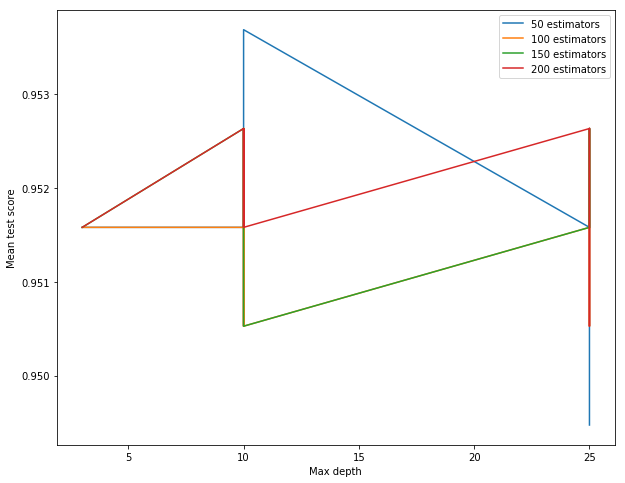

In [26]:
plt.figure(figsize=(10,8))
for n_est in rf_results.param_rfclf__n_estimators.unique():
    df = rf_results[rf_results.param_rfclf__n_estimators == n_est]
    plt.plot(df['param_rfclf__max_depth'],df['mean_test_score'], label = '{} estimators'.format(n_est))
plt.xlabel('Max depth')
plt.ylabel('Mean test score')
plt.legend()

In [27]:
feat_importances = rf_gs.best_estimator_.named_steps['rfclf'].feature_importances_
cols_and_imps = list(zip(X.columns, feat_importances))
cols_and_imps.sort(key=lambda x:x[1], reverse=True)

In [28]:
feat_imp_df = pd.DataFrame(cols_and_imps)
feat_imp_df.rename(columns={1:'importance',0:'column'}, inplace=True)
feat_imp_df.head(10)

,column,importance
0,ERA,0.076080
1,R,0.063386
2,SHO,0.059603
3,RA,0.050950
4,BBA,0.041460
5,attendance,0.039053
6,H,0.037894
7,ER,0.037747
8,HA,0.037361
9,OBP,0.036029


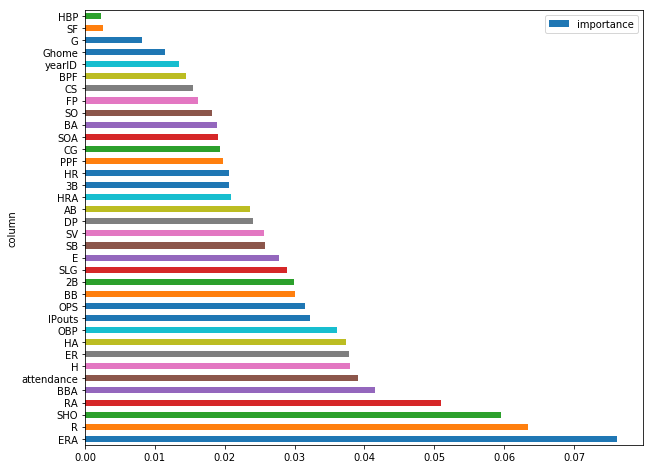

In [29]:
feat_imp_df.plot.barh('column','importance', figsize=(10,8))

### Random Forest Pipeline top 5 Results:


* ERA: Earned Run Average.
* R: Runs scored.
* SHO: Shutouts
* RA: Runs Allowed.
* BBA: Walks Allowed.

Maybe Pitching wins Titles?

## Let's check Permutation Importance

In [30]:
import eli5
from eli5.sklearn import PermutationImportance

Recall our best performing model from above:

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [31]:
# Let's name our best performing model from above.

rf = rf_gs.best_estimator_            
rfclf = rf.fit(X_train, y_train)

In [32]:
# Create PI instance 
perm = PermutationImportance(rfclf, random_state=42).fit(X_test, y_test)

# Visualize Results
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0032 ± 0.0036,SHO
0.0024 ± 0.0009,OPS
0.0024 ± 0.0009,OBP
0.0021 ± 0.0000,H
0.0021 ± 0.0019,attendance
0.0021 ± 0.0019,R
0.0019 ± 0.0016,HA
0.0017 ± 0.0022,BB
0.0015 ± 0.0017,E
0.0013 ± 0.0009,BA


### Will Adaboost improve the score?

In [33]:
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, max_features='auto'), n_estimators=250, learning_rate=.55, random_state=42)
adaboost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.55, n_estimators=250, random_state=42)

In [34]:
adaboost.score(X_train, y_train), adaboost.score(X_test, y_test)

(0.9926276987888363, 0.9572649572649573)

In [35]:
confusion_matrix(y_test, adaboost.predict(X_test))

array([[893,  12],
       [ 28,   3]])

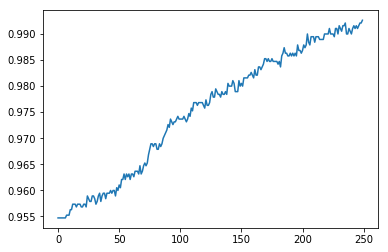

In [36]:
preds = adaboost.staged_predict(X_train)

acc = [accuracy_score(y_train, y_pred) for y_pred in preds]

plt.plot(acc)

In [37]:
adaboost_feat = adaboost.feature_importances_
name_col = list(zip(X.columns, adaboost_feat))
name_col.sort(key=lambda x:x[1], reverse=True)

In [38]:
ada_feat_imp_df = pd.DataFrame(name_col)
ada_feat_imp_df.rename(columns={1:'importance',0:'column'}, inplace=True)
ada_feat_imp_df.head(10)

,column,importance
0,R,0.072
1,attendance,0.068
2,ER,0.056
3,RA,0.052
4,2B,0.048
5,SO,0.044
6,SOA,0.040
7,yearID,0.032
8,H,0.032
9,ERA,0.032


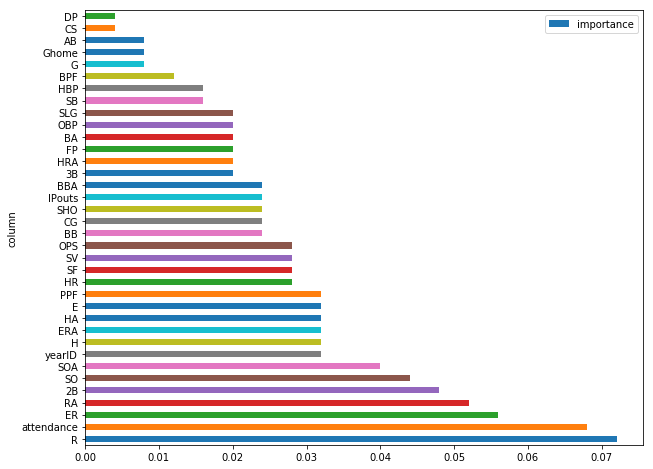

In [39]:
ada_feat_imp_df.plot.barh('column','importance', figsize=(10,8))

### AdaBoost top 5 Results:
* R: Runs scored.
* Attendance: Might have to do with team budget.
* ER: Earned Runs.
* RA: Runs Allowed.
* 2B: Doubles.


## More Pipelines to compare Results

In [40]:
# Construct some pipelines

pipe_lr = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', LogisticRegression(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', svm.SVC(random_state=42))])

pipe_dt = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', DecisionTreeClassifier(random_state=42))])
pipe_knn = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', KNeighborsClassifier())])

# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_svm, pipe_dt, pipe_knn]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Support Vector Machine', 2: 'Decision Tree', 3:  'KNN'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

# Compare accuracies
for idx, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))

# Identify the most accurate model on test data
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.score(X_test, y_test) > best_acc:
        best_acc = val.score(X_test, y_test)
        best_pipe = val
        best_clf = idx
print('Classifier with best accuracy: %s' % pipe_dict[best_clf])



Logistic Regression pipeline test accuracy: 0.967
Support Vector Machine pipeline test accuracy: 0.967
Decision Tree pipeline test accuracy: 0.925
KNN pipeline test accuracy: 0.968
Classifier with best accuracy: KNN


In [41]:
pipe = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', KNeighborsClassifier())])

param_range = [1, 2, 3, 4, 5, 6, 7]
leaf_range = [1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 30]

# Set grid search params
grid_params = [{
        'clf__n_neighbors': param_range,
        'clf__leaf_size': leaf_range,
        }]

# Construct grid search
gs = GridSearchCV(estimator=pipe,
            param_grid=grid_params,
            scoring='accuracy',
            cv=10)

# Fit using grid search
gs.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs.best_score_)

# Best params
print 'Best params:', gs.best_params_

Best accuracy: 0.955
Best params: {'clf__n_neighbors': 4, 'clf__leaf_size': 1}


In [42]:
pred_gs = gs.predict(X_test)

confusion_gs = confusion_matrix(y_test, pred_gs)
print("Confusion matrix:\n{}".format(confusion_gs))

Confusion matrix:
[[905   0]
 [ 31   0]]
